In [1]:
%%time
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, Descriptors

# Defining the SMILES strings for the cucumin varients
curcumin_variants = (
    "COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC)cc(OC)cc1OC)=C2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+][B-](F)(F)O2)c(OC)c3",
    "COc5ccc(C/C=C/C4=[O+][B-](F)(F)OC(/C=C/Cc2c1ccccc1cc3ccccc23)=C4)cc5",
    "COc3ccc(OC)c(C/C=C/C2=CC(/C=C/Cc1cc(OC)ccc1OC)=[O+][B-](F)(F)O2)c3",
    "COc3cc(C/C=C/C2=CC(/C=C/Cc1ccc(O)c(OC)c1)=[O+][B-](F)(F)O2)ccc3O",
    "CN(C)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccccc1)=C2)cc3",
    "COc6ccc(C/C=C/C5=CC(/C=C/Cc1cc2ccc3cccc4ccc(c1)c2c34)=[O+][B-](F)(F)O5)cc6",
    "COc4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(OC)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CN(C)c4ccc(C/C=C/C3=CC(/C=C/Cc1ccc(N(C)C)c2ccccc12)=[O+][B-](F)(F)O3)c5ccccc45",
    "CCCCN(CCCC)c3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(CCCC)CCCC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(C#N)cc1)=[O+][B-](F)(F)O2)cc3",
    "CN5/C(=C\C\C=C\C3=CC(/C=C/C/C=C/2N(C)c1ccccc1C2(C)C)=[O+][B-](F)(F)O3)C(C)(C)c4ccccc45",
    "COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc(SC)cc1)=C2)cc3",
    "CSc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(SC)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(N(C)C)cc1)=[O+][B-](F)(F)O2)cc3",
    "COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B-](F)(F)O3",
    "CCCCCC(CC)c5ccc(c4ccc(C/C=C/C3=CC(/C=C/Cc2ccc(c1ccc(C(CC)CCCCC)s1)s2)=[O+][B-](F)(F)O3)s4)s5"
)

molecule_names = ['2-ADMeO3', '3-MR83a', 'AD-10', 'AD-1013', 'AD-1022', 'AD-11', 'AD-14-Moore', 'AD-16-DMF', 'AD-18', 'AD-24', 'AD-25', 'AD-35', 'AD-4', 'AD-48', 'AD-5', 'AD-6', 'AD-7', 'AD-9', 'YD-30']
homo_lumo_gap = [3.077, 3.072, 3.259, 2.625, 2.938, 2.946, 2.811, 3.231, 2.735, 2.878, 2.686, 2.77, 3.001, 2.702, 2.97, 2.89, 2.859, 3.137, 2.525]

molecules = [Chem.MolFromSmiles(smiles) for smiles in curcumin_variants]
mws = [round(Descriptors.MolWt(mol),3) for mol in molecules]
logp = [Descriptors.MolLogP(mol) for mol in molecules]

# Create the initial DataFrame
data = {
    'Molecule': molecule_names,
    'Molecular Weight': mws,
    'LogP': logp,
    'Homo-Lumo Gap (eV)': homo_lumo_gap,
    'Smiles': curcumin_variants
}
curcumin_df = pd.DataFrame(data)
curcumin_df['mol'] = curcumin_df['Smiles'].apply(Chem.MolFromSmiles)

# Harvard OPV dataset import
data = pd.read_csv('https://raw.githubusercontent.com/AjStephan/havard-smile-opv/main/Non-fullerene%20small-molecules%20acceptors.csv')
opv_df = data.drop(columns=[
    'index', 'inchikey', 'LUMO_calib_stds', 'HOMO_calib_stds',
    'molW', 'PCE_calc', 'Voc_calc', 'Jsc_calc',
    'FF_calc', 'EQE_calc', 'PCE_calib', 'Voc_calib', 'Jsc_calib', 'FF_calib',
    'EQE_calib', 'PCE_cdiff', 'PCE_calib_plus'], axis=1)

opv_df['mol'] = opv_df['smiles'].apply(Chem.MolFromSmiles)

CPU times: total: 10.8 s
Wall time: 13.1 s


In [2]:
opv_df_sorted = opv_df.sort_values(by='LUMO_calc')
opv_df_filtered = opv_df_sorted[opv_df_sorted['LUMO_calc'] <= -3.5]
opv_df_filtered.reset_index(drop=True, inplace=True)
opv_df_filtered

,smiles,HOMO_calc,LUMO_calc,LUMO_calib,HOMO_calib,GAP_calib,GAP_calc,mol
0,CN1C(=O)C2=C(C3=C(C#N)C(=C(C#N)C#N)SC3=O)N(C)C...,-6.884480,-5.415066,-5.785082,-6.877951,1.092869,1.469415,<rdkit.Chem.rdchem.Mol object at 0x000001C2225...
1,N#CC(C#N)=C1SC(=O)C(c2cnc(C3=C(C#N)C(=C(C#N)C#...,-7.972936,-5.351299,-5.658418,-8.008956,2.350538,2.621637,<rdkit.Chem.rdchem.Mol object at 0x000001C2225...
2,O=C(O)c1noc(-c2c3c(c(-c4onc(C(=O)O)c4C(=O)O)c4...,-7.091046,-5.349517,-5.779633,-7.231863,1.452230,1.741529,<rdkit.Chem.rdchem.Mol object at 0x000001C220B...
3,N#CC(C#N)=C1C=C(C(=O)O)OC(c2c3c(c(C4=CC(=C(C#N...,-6.754826,-5.224586,-5.484103,-6.830958,1.346855,1.530241,<rdkit.Chem.rdchem.Mol object at 0x000001C2223...
4,N#Cc1noc(-c2c3c(c(-c4onc(C#N)c4C(=O)O)c4cscc24...,-6.993326,-5.185199,-5.519700,-7.083920,1.564220,1.808127,<rdkit.Chem.rdchem.Mol object at 0x000001C220B...
...,...,...,...,...,...,...,...,...
12717,CN1C(=O)C(=Cc2nc3ccc(-c4cocc4C(=O)c4ccc(C(F)(F...,-6.654575,-3.500147,-3.991776,-6.753528,2.761752,3.154428,<rdkit.Chem.rdchem.Mol object at 0x000001C220A...
12718,CN1C(=O)C(=Cc2ncc(-c3ccnc(-c4c5ccsc5nc5sc(F)c(...,-6.205515,-3.500108,-4.002464,-6.292875,2.290410,2.705406,<rdkit.Chem.rdchem.Mol object at 0x000001C2695...
12719,CN1C(=O)C(=Cc2nccc(C=CC(=O)C=Cc3ccnc(C=C4SC(=S...,-6.304187,-3.500102,-3.838015,-6.314939,2.476924,2.804085,<rdkit.Chem.rdchem.Mol object at 0x000001C220B...
12720,CN1C(=O)C(=Cc2onc(-c3ncnc([SiH]4C=C5OCCOC5=C4)...,-6.185529,-3.500038,-4.152998,-6.280591,2.127593,2.685491,<rdkit.Chem.rdchem.Mol object at 0x000001C220A...


In [3]:
%%time
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem, MACCSkeys, rdMolDescriptors
from rdkit.DataStructs import ExplicitBitVect
import numpy as np

# Functions to generate fingerprints
def generate_morgan_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits)

def generate_maccs166_fingerprint(mol):
    return MACCSkeys.GenMACCSKeys(mol)

def generate_atom_pair_fingerprint(mol, nBits=2048):
    fp = rdMolDescriptors.GetAtomPairFingerprint(mol)
    return convert_to_bit_vector(fp, nBits)

def generate_fcfp_fingerprint(mol, radius=2, nBits=2048):
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=True)

# Convert any fingerprint to a bit vector
def convert_to_bit_vector(fp, nBits=2048):
    bit_vector = ExplicitBitVect(nBits)
    for bit in fp.GetNonzeroElements().keys():
        bit_vector.SetBit(bit % nBits)
    return bit_vector

# Function to add fingerprint to dataframe
def add_fingerprint_to_df(df, fingerprint_func, fp_name):
    df[fp_name] = df['mol'].apply(fingerprint_func)
    return df

# Function to split fingerprints into separate bit columns
def split_fingerprint_bits(df, fp_column, prefix):
    bit_array = np.array([list(fp) for fp in df[fp_column].values])
    bit_columns = pd.DataFrame(bit_array, columns=[f'{prefix}_{i}' for i in range(bit_array.shape[1])])
    df = pd.concat([df.drop(columns=[fp_column]), bit_columns], axis=1)
    return df

# Assuming opv_df is already defined and 'mol' column has been created
# List of fingerprint generation functions and names
fingerprint_functions = [
    (generate_morgan_fingerprint, 'morgan_fp', 'morgan'),
    (generate_maccs166_fingerprint, 'maccs_fp', 'maccs'),
    (generate_atom_pair_fingerprint, 'atom_pair_fp', 'atom_pair'),
    (generate_fcfp_fingerprint, 'fcfp_fp', 'fcfp')
]

# List to store resulting dataframes
resulting_dfs = []

# Generate and store dataframes with fingerprints
for fp_func, fp_name, prefix in fingerprint_functions:
    df_copy = opv_df_filtered.copy()
    df_copy = add_fingerprint_to_df(df_copy, fp_func, fp_name)
    df_copy = split_fingerprint_bits(df_copy, fp_name, prefix)
    resulting_dfs.append(df_copy)
    print(f'Finished processing {prefix} fingerprints')

# The resulting_dfs list now contains your four dataframes with split fingerprint columns
opv_df_morgan = resulting_dfs[0]
opv_df_maccs = resulting_dfs[1]
opv_df_atom_pair = resulting_dfs[2]
opv_df_fcfp = resulting_dfs[3]

Finished processing morgan fingerprints
Finished processing maccs fingerprints
Finished processing atom_pair fingerprints
Finished processing fcfp fingerprints
CPU times: total: 53.7 s
Wall time: 55.6 s


In [4]:
opv_df_morgan.shape

(12722, 2056)

In [5]:
%%time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

models = {
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(),
    'LightGBM': LGBMRegressor(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor()
}

results = []

for i, df in enumerate([opv_df_morgan, opv_df_maccs, opv_df_atom_pair, opv_df_fcfp]):
    fingerprint_type = ['Morgan', 'MACCS', 'Atom Pair', 'FCFP'][i]
    
    X = df.iloc[:,8:]  
    y = df["GAP_calc"] 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)

        print(f'Finished processing {fingerprint_type} fingerprints with {model_name} model:')
        
        results.append({
            'Fingerprint Type': fingerprint_type,
            'Regression Model': model_name,
            'R² Score': r2,
            'RMSE': rmse,
            'MAE': mae,
            'MSE': mse
        })
    print(f'Finished processing {fingerprint_type} fingerprints')

results_df = pd.DataFrame(results)
results_df

Finished processing Morgan fingerprints with Bayesian Ridge model:
Finished processing Morgan fingerprints with KNN Regressor model:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 9541, number of used features: 1145
[LightGBM] [Info] Start training from score 2.700884
Finished processing Morgan fingerprints with LightGBM model:
Finished processing Morgan fingerprints with Ridge Regression model:
Finished processing Morgan fingerprints with Decision Tree model:
Finished processing Morgan fingerprints
Finished processing MACCS fingerprints with Bayesian Ridge model:
Finished processing MACCS fingerprints with KNN Regressor model:
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.00071

,Fingerprint Type,Regression Model,R² Score,RMSE,MAE,MSE
0,Morgan,Bayesian Ridge,0.771279,0.285303,0.147993,0.081398
1,Morgan,KNN Regressor,0.710754,0.320839,0.165786,0.102938
2,Morgan,LightGBM,0.800350,0.266556,0.123674,0.071052
3,Morgan,Ridge Regression,0.772076,0.284806,0.147027,0.081114
4,Morgan,Decision Tree,0.751522,0.297370,0.143728,0.088429
5,MACCS,Bayesian Ridge,0.577105,0.387945,0.260165,0.150501
6,MACCS,KNN Regressor,0.658628,0.348552,0.207706,0.121488
7,MACCS,LightGBM,0.708941,0.321843,0.189376,0.103583
8,MACCS,Ridge Regression,0.577384,0.387817,0.260114,0.150402
9,MACCS,Decision Tree,0.707032,0.322896,0.186606,0.104262


In [6]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Find the best combinations for each metric
best_r2 = results_df.loc[results_df['R² Score'].idxmax()]
best_rmse = results_df.loc[results_df['RMSE'].idxmin()]
best_mae = results_df.loc[results_df['MAE'].idxmin()]

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    yaxis=dict(range=[0, 1.2]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_r2.add_annotation(
    x=best_r2['Regression Model'],
    y=best_r2['R² Score'],
    text=f"Best: {best_r2['Regression Model']} ({best_r2['Fingerprint Type']})<br>R² Score: {best_r2['R² Score']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-150,
    ay=-50,
    bordercolor="black",
    borderwidth=1
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    yaxis=dict(range=[0, 0.6]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_rmse.add_annotation(
    x=best_rmse['Regression Model'],
    y=best_rmse['RMSE'],
    text=f"Best: {best_rmse['Regression Model']} ({best_rmse['Fingerprint Type']})<br>RMSE: {best_rmse['RMSE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(results_df['Fingerprint Type'].unique()):
    subset = results_df[results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type - Initial Model',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    yaxis=dict(range=[0, 0.5]),
    barmode='group',
    legend_title='Fingerprint Type',
    legend=dict(orientation="h", yanchor="top", y=1.15, xanchor="center", x=0.5)
)

fig_mae.add_annotation(
    x=best_mae['Regression Model'],
    y=best_mae['MAE'],
    text=f"Best: {best_mae['Regression Model']} ({best_mae['Fingerprint Type']})<br>MAE: {best_mae['MAE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

In [7]:
path = (r"C:\Users\Chamod Peiris\Documents\Curcumin_Scripts\initcurcumin_optimizedparams.csv")
parameters = pd.read_csv(path).iloc[:,:3]
parameters

,Fingerprint Type,Regression Model,Best Parameters
0,Morgan,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti..."
1,Morgan,Bayesian Ridge,"{'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_..."
2,Morgan,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}"
3,Morgan,Ridge,{'alpha': 1.0}
4,Morgan,Decision Tree,"{'max_depth': None, 'min_samples_leaf': 2, 'mi..."
5,MACCS,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti..."
6,MACCS,Bayesian Ridge,"{'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_..."
7,MACCS,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}"
8,MACCS,Ridge,{'alpha': 0.1}
9,MACCS,Decision Tree,"{'max_depth': 30, 'min_samples_leaf': 2, 'min_..."


In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

# Initialize models (without parameters for now)
models = {
    'LightGBM': LGBMRegressor(),
    'Bayesian Ridge': BayesianRidge(),
    'KNN Regressor': KNeighborsRegressor(),
    'Ridge': Ridge(),
    'Decision Tree': DecisionTreeRegressor()
}

# Initialize an empty list to store the optimized results
optimized_results = []

# Iterate over the four dataframes
for i, df in enumerate([opv_df_morgan, opv_df_maccs, opv_df_atom_pair, opv_df_fcfp]):
    fingerprint_type = ['Morgan', 'MACCS', 'Atom Pair', 'FCFP'][i]
    
    X = df.iloc[:, 8:]  
    y = df["GAP_calc"]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    
    # Filter the 'parameters' DataFrame for this fingerprint type
    param_subset = parameters[parameters['Fingerprint Type'] == fingerprint_type]
    
    # Iterate over the models to apply best parameters from the 'parameters' DataFrame
    for model_name in models.keys():
        # Extract best parameters for the current model and fingerprint type
        best_params_row = param_subset[param_subset['Regression Model'] == model_name]
        
        if not best_params_row.empty:
            # Extract the best parameters as a dictionary
            best_params = eval(best_params_row.iloc[0]['Best Parameters'])  # Assuming parameters are stored as a dictionary string

            # Update the model with the best parameters
            model = models[model_name].set_params(**best_params)
            
            print(f'Training {model_name} model with {fingerprint_type} fingerprints and best parameters...')
            
            # Train the model
            model.fit(X_train, y_train)
            
            # Make predictions using the trained model
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            r2 = r2_score(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            mae = mean_absolute_error(y_test, y_pred)
            mse = mean_squared_error(y_test, y_pred)
            
            # Append the results to the optimized_results list
            optimized_results.append({
                'Fingerprint Type': fingerprint_type,
                'Regression Model': model_name,
                'Best Parameters': best_params,
                'R² Score': r2,
                'RMSE': rmse,
                'MAE': mae,
                'MSE': mse
            })
            
            print(f'Finished processing {fingerprint_type} fingerprints with optimized {model_name} model')
            
# Convert the results to a DataFrame for analysis
optimized_results_df = pd.DataFrame(optimized_results)
optimized_results_df

Training LightGBM model with Morgan fingerprints and best parameters...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 9541, number of used features: 1145
[LightGBM] [Info] Start training from score 2.700884
Finished processing Morgan fingerprints with optimized LightGBM model
Training Bayesian Ridge model with Morgan fingerprints and best parameters...
Finished processing Morgan fingerprints with optimized Bayesian Ridge model
Training KNN Regressor model with Morgan fingerprints and best parameters...
Finished processing Morgan fingerprints with optimized KNN Regressor model
Training Ridge model with Morgan fingerprints and best parameters...
Finished processing Morgan fingerprints with optimized Ridge model
Training 

,Fingerprint Type,Regression Model,Best Parameters,R² Score,RMSE,MAE,MSE
0,Morgan,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti...",0.834221,0.242895,0.089606,0.058998
1,Morgan,Bayesian Ridge,"{'alpha_1': 1e-06, 'alpha_2': 0.0001, 'lambda_...",0.771279,0.285303,0.147993,0.081398
2,Morgan,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.724244,0.313268,0.162929,0.098137
3,Morgan,Ridge,{'alpha': 1.0},0.772076,0.284806,0.147027,0.081114
4,Morgan,Decision Tree,"{'max_depth': None, 'min_samples_leaf': 2, 'mi...",0.740124,0.304114,0.141089,0.092485
5,MACCS,LightGBM,"{'learning_rate': 0.23685145356420312, 'n_esti...",0.723474,0.313705,0.176918,0.098411
6,MACCS,Bayesian Ridge,"{'alpha_1': 0.0001, 'alpha_2': 1e-06, 'lambda_...",0.577105,0.387945,0.260165,0.150501
7,MACCS,KNN Regressor,"{'n_neighbors': 7, 'p': 1, 'weights': 'distance'}",0.686137,0.334213,0.193059,0.111699
8,MACCS,Ridge,{'alpha': 0.1},0.577596,0.387719,0.260026,0.150326
9,MACCS,Decision Tree,"{'max_depth': 30, 'min_samples_leaf': 2, 'min_...",0.702942,0.325143,0.187278,0.105718


In [9]:
import plotly.graph_objects as go
import pandas as pd

# Define colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Order of regression models
model_order = ['Bayesian Ridge', 'KNN Regressor', 'LightGBM', 'Ridge', 'Decision Tree']

# Find the best combinations for each metric
best_r2 = optimized_results_df.loc[optimized_results_df['R² Score'].idxmax()]
best_rmse = optimized_results_df.loc[optimized_results_df['RMSE'].idxmin()]
best_mae = optimized_results_df.loc[optimized_results_df['MAE'].idxmin()]

# Create traces for R² Score
fig_r2 = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_r2.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['R² Score'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['R² Score']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_r2.update_layout(
    title='R² Score by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='R² Score',
    barmode='group',
    yaxis=dict(range=[0, 1.1]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order),
    legend=dict(orientation="h", yanchor="top", y=1.08, xanchor="center", x=0.5),
    width=900, height=600
)

fig_r2.add_annotation(
    x=best_r2['Regression Model'],
    y=best_r2['R² Score'],
    text=f"Best: {best_r2['Regression Model']} ({best_r2['Fingerprint Type']})<br>R² Score: {best_r2['R² Score']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-150,
    ay=-35,
    bordercolor="black",
    borderwidth=1
)

# Create traces for RMSE
fig_rmse = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_rmse.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['RMSE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['RMSE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_rmse.update_layout(
    title='RMSE by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='RMSE',
    barmode='group',
    yaxis=dict(range=[0, 0.45]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order)  # Set the order of models
)

fig_rmse.add_annotation(
    x=best_rmse['Regression Model'],
    y=best_rmse['RMSE'],
    text=f"Best: {best_rmse['Regression Model']} ({best_rmse['Fingerprint Type']})<br>RMSE: {best_rmse['RMSE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Create traces for MAE
fig_mae = go.Figure()
for idx, fingerprint_type in enumerate(optimized_results_df['Fingerprint Type'].unique()):
    subset = optimized_results_df[optimized_results_df['Fingerprint Type'] == fingerprint_type]
    fig_mae.add_trace(go.Bar(
        x=subset['Regression Model'],
        y=subset['MAE'],
        name=fingerprint_type,
        text=[f'{val:.5f}' for val in subset['MAE']],
        textposition='inside',
        marker_color=colors[idx % len(colors)],
    ))

fig_mae.update_layout(
    title='MAE by Regression Model and Fingerprint Type - Optimized Model',
    xaxis_title='Regression Model',
    yaxis_title='MAE',
    barmode='group',
    yaxis=dict(range=[0, 0.35]),
    legend_title='Fingerprint Type',
    xaxis=dict(categoryorder='array', categoryarray=model_order)  # Set the order of models
)

fig_mae.add_annotation(
    x=best_mae['Regression Model'],
    y=best_mae['MAE'],
    text=f"Best: {best_mae['Regression Model']} ({best_mae['Fingerprint Type']})<br>MAE: {best_mae['MAE']:.5f}",
    showarrow=True,
    arrowhead=2,
    ax=-100,
    ay=-120,
    bordercolor="black",
    borderwidth=1
)

# Show the plots
fig_r2.show()
fig_rmse.show()
fig_mae.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 1157
[LightGBM] [Info] Start training from score 2.703028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000845 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 102
[LightGBM] [Info] Start training from score 2.703028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003186 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

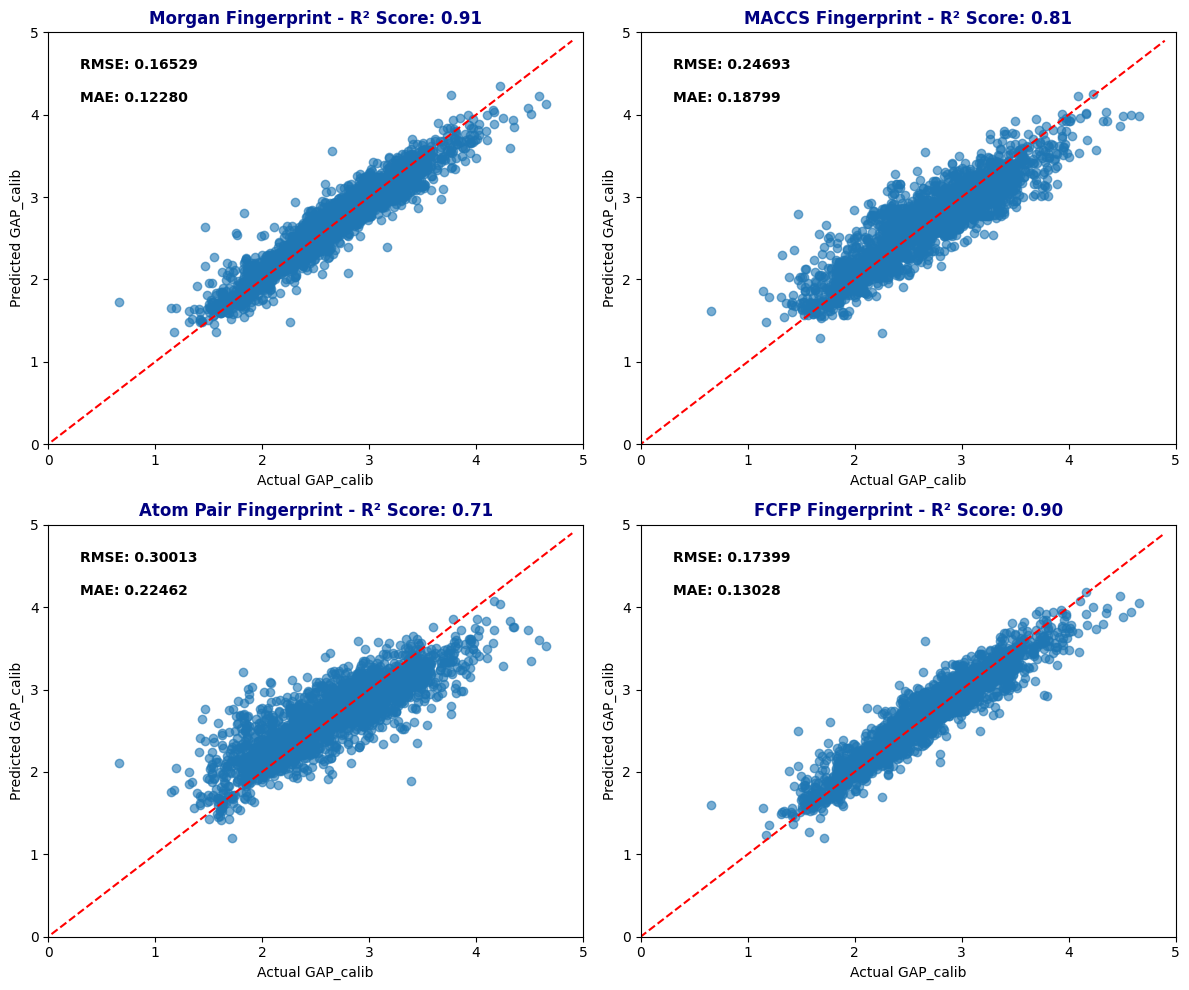

In [10]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming the LightGBM model is already defined and trained
# Define the dataframes and corresponding names
dataframes = {
    'Morgan': opv_df_morgan,
    'MACCS': opv_df_maccs,
    'Atom Pair': opv_df_atom_pair,
    'FCFP': opv_df_fcfp
}

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Iterate over the dataframes and plot actual vs predicted
for idx, (fingerprint_name, df) in enumerate(dataframes.items()):
    X = df.iloc[:, 8:]  # Features
    y = df["GAP_calc"]  # Target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the LightGBM model
    lgbm_model = lgb.LGBMRegressor()
    lgbm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)

    # Calculate R² Score
    r2_score = lgbm_model.score(X_test, y_test)

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))

    # Plot the actual vs predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
    axes[idx].set_title(f'{fingerprint_name} Fingerprint - R² Score: {r2_score:.2f}', fontsize=12, weight='bold', color='navy')
    axes[idx].set_xlabel('Actual GAP_calib')
    axes[idx].set_ylabel('Predicted GAP_calib')

    # X and Y limits
    axes[idx].set_xlim(0,5)
    axes[idx].set_ylim(0,5)

    # Add RMSE and MAE to the plot
    axes[idx].text(0.3, 4.55, f'RMSE: {rmse:.5f}', fontsize=10, color='black', weight='bold')
    axes[idx].text(0.3, 4.15, f'MAE: {mae:.5f}', fontsize=10, color='black', weight='bold')

    # Draw a square around the text and set the background color to white
    axes[idx].add_patch(plt.Rectangle((0.1, 5.05), 1.6, 0.8, fill='white', color='navy', alpha=0.2))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 1157
[LightGBM] [Info] Start training from score 2.703028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 204
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 102
[LightGBM] [Info] Start training from score 2.703028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

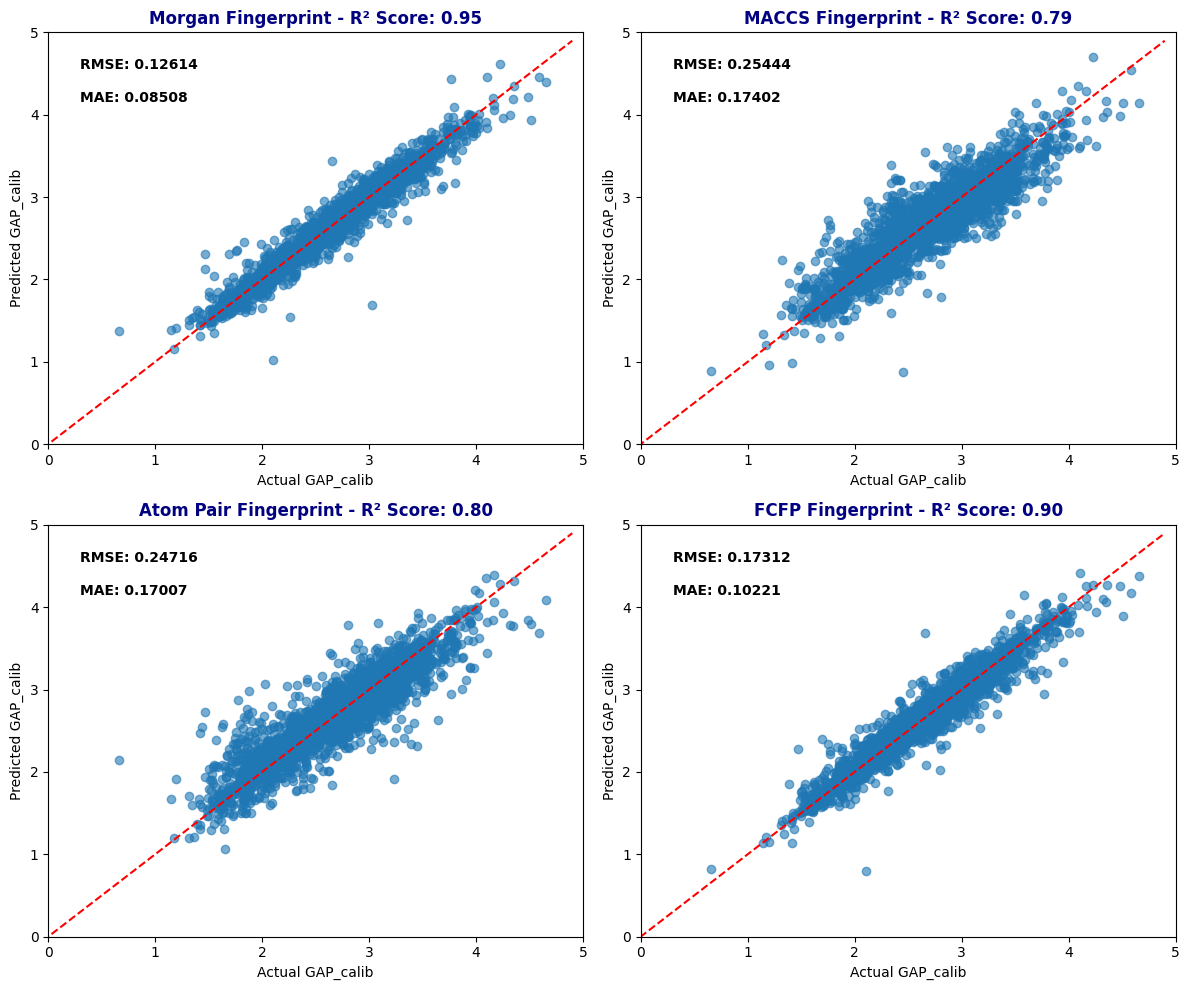

In [11]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Optimized LightGBM parameters
lgbm_params = {
    'learning_rate': 0.23685145356420312,
    'n_estimators': 1000,
    'num_leaves': 51
}

# Define the dataframes and corresponding names
dataframes = {
    'Morgan': opv_df_morgan,
    'MACCS': opv_df_maccs,
    'Atom Pair': opv_df_atom_pair,
    'FCFP': opv_df_fcfp
}

# Set up the plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the 2x2 array of axes for easier iteration

# Iterate over the dataframes and plot actual vs predicted
for idx, (fingerprint_name, df) in enumerate(dataframes.items()):
    X = df.iloc[:, 8:]  # Features
    y = df["GAP_calc"]  # Target

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train the LightGBM model with optimized parameters
    lgbm_model = lgb.LGBMRegressor(**lgbm_params)
    lgbm_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lgbm_model.predict(X_test)

    # Calculate R² Score
    r2_score = lgbm_model.score(X_test, y_test)

    # Calculate RMSE, R2 Score, and MAE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = np.mean(np.abs(y_test - y_pred))

    # Plot the actual vs predicted
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')  # 45-degree line
    axes[idx].set_title(f'{fingerprint_name} Fingerprint - R² Score: {r2_score:.2f}', fontsize=12, weight='bold', color='navy')   
    axes[idx].set_xlabel('Actual GAP_calib')
    axes[idx].set_ylabel('Predicted GAP_calib')

    # Set the limits for the x and y axes
    axes[idx].set_xlim(0,5)
    axes[idx].set_ylim(0,5)


    # Add RMSE and MAE to the plot
    axes[idx].text(0.3, 4.55, f'RMSE: {rmse:.5f}', fontsize=10, color='black', weight='bold')
    axes[idx].text(0.3, 4.15, f'MAE: {mae:.5f}', fontsize=10, color='black', weight='bold')

    # Draw a square around the text and set the background color to white
    axes[idx].add_patch(plt.Rectangle((0.1, 5.05), 1.6, 0.8, fill='white', color='navy', alpha=0.2))

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [12]:
curcumin_df_mf = curcumin_df.copy()
curcumin_df_mf['Morgan_Fingerprints'] = curcumin_df_mf['mol'].apply(
    lambda x: list(AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=2048))
)
curcumin_df_mf.head()

# convert the fingerprints to a DataFrame
morgan_df = pd.DataFrame(curcumin_df_mf['Morgan_Fingerprints'].tolist(), columns=[f'morgan_{i}' for i in range(2048)])
curcumin_df_mf = pd.concat([curcumin_df_mf.drop(columns=['Morgan_Fingerprints']), morgan_df], axis=1)
curcumin_df_mf = curcumin_df_mf.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)
curcumin_df_mf.head()

,Molecule,Molecular Weight,LogP,Homo-Lumo Gap (eV),Smiles,mol,morgan_0,morgan_1,morgan_2,morgan_3,...,morgan_2038,morgan_2039,morgan_2040,morgan_2041,morgan_2042,morgan_2043,morgan_2044,morgan_2045,morgan_2046,morgan_2047
0,AD-10,472.293,5.01210,3.259,COc3ccc(C/C=C/C2=CC(/C=C/Cc1ccc(OC)cc1OC)=[O+]...,<rdkit.Chem.rdchem.Mol object at 0x000001C21F3...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AD-16-DMF,377.199,4.84938,3.231,N#Cc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1ccc...,<rdkit.Chem.rdchem.Mol object at 0x000001C21F3...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AD-9,412.241,4.99490,3.137,COc1ccccc1C/C=C/C3=CC(/C=C/Cc2ccccc2OC)=[O+][B...,<rdkit.Chem.rdchem.Mol object at 0x000001C21F3...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2-ADMeO3,532.345,5.02930,3.077,COc3cc(OC)c(C/C=C/C2=CC(/C=C/Cc1c(OC)cc(OC)cc1...,<rdkit.Chem.rdchem.Mol object at 0x000001C21F3...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3-MR83a,472.293,5.01210,3.072,COc3ccc(C/C=C/C2=[O+][B-](F)(F)OC(/C=C/Cc1c(OC...,<rdkit.Chem.rdchem.Mol object at 0x000001C21F3...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
import numpy as np
x = opv_df_morgan.iloc[:, 8:]
y = opv_df_morgan["GAP_calc"]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

lgbm_model = lgb.LGBMRegressor(**lgbm_params)
lgbm_model.fit(X_train, y_train)

# Make predictions and calculate R^2 score
y_pred = lgbm_model.predict(X_test)

# Calculate R2 score
from sklearn.metrics import r2_score
r2_model = r2_score(y_test, y_pred)

from sklearn.metrics import mean_squared_error
rmse_model = mean_squared_error(y_test, y_pred, squared=False)

curcumin_df_mf_pred = curcumin_df_mf.copy()
curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'] = lgbm_model.predict(curcumin_df_mf.iloc[:, 6:])

r2_predict = r2_score(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])
rmse_predict = mean_squared_error(curcumin_df_mf_pred['Homo-Lumo Gap (eV)'],curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'])

print(f"Model Calculated LUMO value filered R2 Score: {r2_model} & RMSE value: {rmse_model}")
print(f"Prediction with Calculated LUMO value filered model R2 Score: {r2_predict} & RMSE value: {rmse_predict}")  

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008479 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2314
[LightGBM] [Info] Number of data points in the train set: 10177, number of used features: 1157
[LightGBM] [Info] Start training from score 2.703028
Model Calculated LUMO value filered R2 Score: 0.9491433910968702 & RMSE value: 0.1261372422730882
Prediction with Calculated LUMO value filered model R2 Score: 0.36445535466461443 & RMSE value: 0.024409544526078897


c:\Users\Chamod Peiris\Documents\GitHub\Curcumin_BendGap_Cheminfo\.venv\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



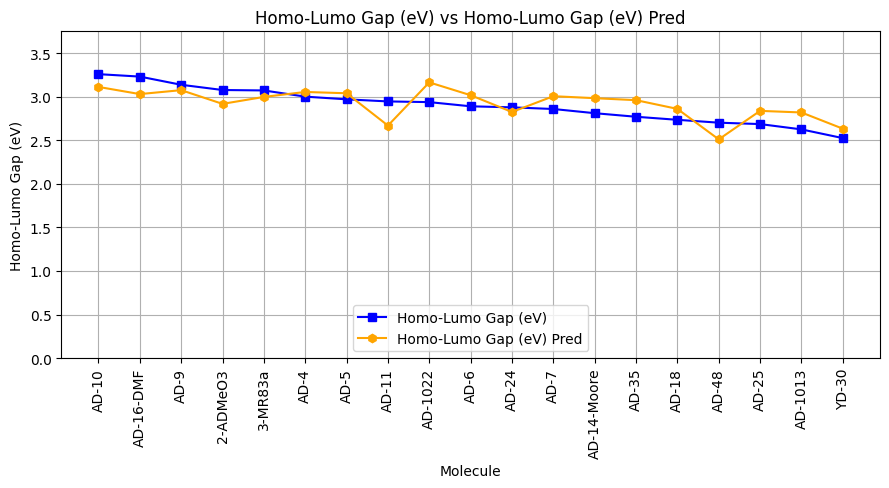

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 4))
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Homo-Lumo Gap (eV)', color='blue')
plt.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred[f'Homo-Lumo Gap (eV) Pred'], marker='h', label=f'Homo-Lumo Gap (eV) Pred', color='orange')
plt.xlabel('Molecule')
plt.ylabel('Homo-Lumo Gap (eV)')
plt.grid(True)
plt.tight_layout()
plt.title(f'Homo-Lumo Gap (eV) vs Homo-Lumo Gap (eV) Pred')
plt.legend()
plt.legend(loc='lower center')
plt.ylim(0, 3.75)
plt.xticks(rotation=90)
plt.show()

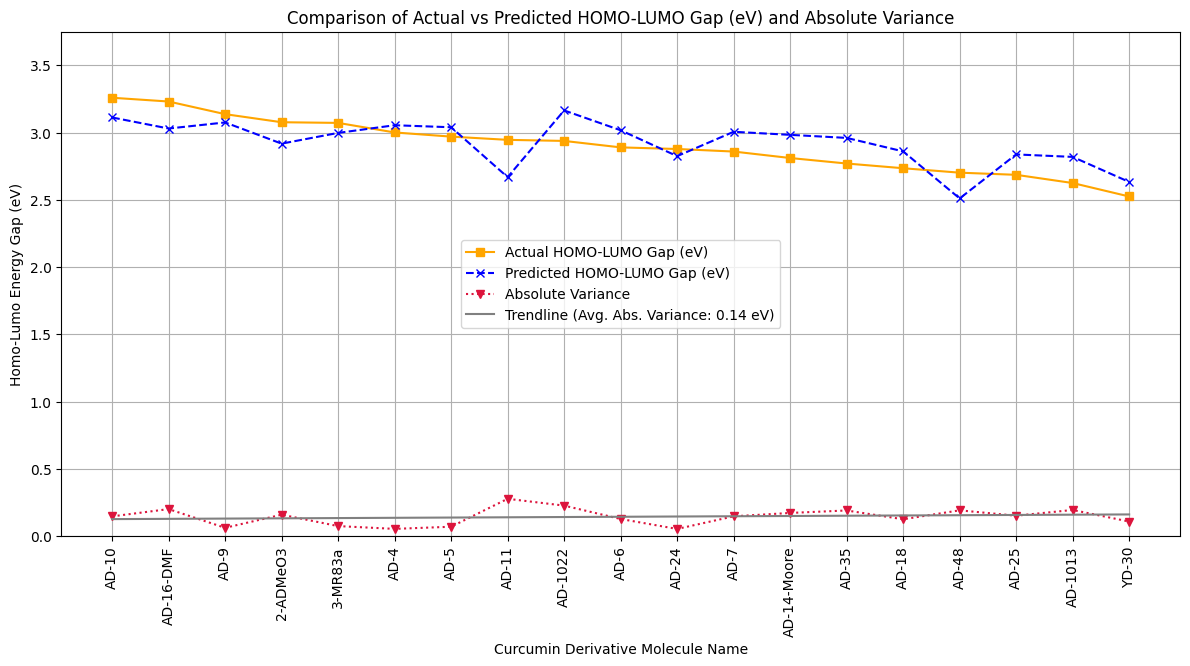

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming curcumin_df_mf_pred already has a 'Homo-Lumo Gap (eV) Predicted' column from the previous steps

# Sort curcumin_df_mf_pred by 'Homo-Lumo Gap (eV)' in descending order and reset the index
curcumin_df_mf_pred = curcumin_df_mf_pred.sort_values(by='Homo-Lumo Gap (eV)', ascending=False).reset_index(drop=True)

# Calculate the absolute variance between 'Homo-Lumo Gap (eV)' and 'Homo-Lumo Gap (eV) Predicted'
curcumin_df_mf_pred['absolute_variance'] = (curcumin_df_mf_pred['Homo-Lumo Gap (eV)'] - curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred']).abs()

# Calculate linear trendline for absolute variance
x = curcumin_df_mf_pred.index
y = curcumin_df_mf_pred['absolute_variance']
coefficients = np.polyfit(x, y, 1)  # Fit a linear polynomial
trendline = np.polyval(coefficients, x)

# Calculate the average absolute variance
average_variance = y.mean()

# Plotting the actual vs predicted energy gaps
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the actual values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV)'], marker='s', label='Actual HOMO-LUMO Gap (eV)', color='orange')

# Plot the predicted values
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['Homo-Lumo Gap (eV) Pred'], marker='x', linestyle='--', label='Predicted HOMO-LUMO Gap (eV)', color='blue')

# Plot the absolute variance as a dotted line
ax1.plot(curcumin_df_mf_pred['Molecule'], curcumin_df_mf_pred['absolute_variance'], marker='v', linestyle=':', label='Absolute Variance', color='crimson')

# Plot the trendline for absolute variance
ax1.plot(curcumin_df_mf['Molecule'], trendline, linestyle='-', color='grey', label=f'Trendline (Avg. Abs. Variance: {average_variance:.2f} eV)')

# Set labels for the axes and the range
ax1.set_xlabel('Curcumin Derivative Molecule Name')
ax1.set_ylabel('Homo-Lumo Energy Gap (eV)')
ax1.set_ylim([0, 3.75])  # Adjust the y-axis range as needed
ax1.tick_params(axis='y')
ax1.legend(loc='upper right')

# Customize the plot
plt.title('Comparison of Actual vs Predicted HOMO-LUMO Gap (eV) and Absolute Variance')
plt.grid(True)
plt.legend(loc='center')
plt.tight_layout()
plt.xticks(rotation=90)

# Show the plot
plt.show()